AIM :  to predict blood pressure (BP) — specifically Systolic (SBP) and Diastolic (DBP) — using PPG and optionally ECG signals, without using a cuff. 

IMPORTING LIBRARIES


In [156]:
import numpy as np, pandas as pd, seaborn as sns
import scipy.io
from scipy import signal
from scipy.fftpack import fft, dct
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import os

from sklearn.svm import SVR
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold



In [157]:
os.listdir('/kaggle/input/cuff-less-blood-pressure-estimation')


['part_4.mat',
 'part_9.mat',
 'part_10.mat',
 'Samples',
 'part_11.mat',
 'part_3.mat',
 'part_1.mat',
 'part_8.mat',
 'part_5.mat',
 'part_6.mat',
 'part_7.mat',
 'part_2.mat',
 'part_12.mat']

In [158]:
sample_file = scipy.io.loadmat(f'/kaggle/input/cuff-less-blood-pressure-estimation/part_1.mat')
print(type(sample_file))  # dict
print(sample_file.keys())  #  keys


<class 'dict'>
dict_keys(['__header__', '__version__', '__globals__', 'p'])


In [159]:
test_sample = scipy.io.loadmat(f'/kaggle/input/cuff-less-blood-pressure-estimation/part_1.mat')['p']

print(type(test_sample))  # numpy array
print(test_sample.shape)  # (1, 1000)


<class 'numpy.ndarray'>
(1, 1000)


In [ ]:
print(len(test_sample[0]))               # 1000 records
print(len(test_sample[0][0]))                # 3 signal rows (PPG, ABP, ECG)
print(len(test_sample[0][0][2]))                 # Number of samples 61000


1000
3
61000


In [161]:
ppg = []
ecg = []
bp = []
sbp = []  # systolic
dbp = []  # diastolic
sample_size = 125  # 1 second  , sampling rate is 125 Hz

for i in range(1000):
    temp_mat = test_sample[0, i]
    temp_length = temp_mat.shape[1]
    for j in range(temp_length // sample_size):
        temp_ecg = temp_mat[2, j*sample_size:(j+1)*sample_size]  # ECG 
        temp_bp = temp_mat[1, j*sample_size:(j+1)*sample_size]   # BP 
        temp_ppg = temp_mat[0, j*sample_size:(j+1)*sample_size]  # PPG

        
        max_value = max(temp_bp)  # SBP
        min_value = min(temp_bp)  # DBP

        ecg.append(temp_ecg)
        bp.append(temp_bp)
        sbp.append(max_value)
        dbp.append(min_value)
        ppg.append(temp_ppg)


In [162]:
ppg = np.array(ppg).reshape(-1, 1)
ecg = np.array(ecg).reshape(-1, 1)
bp = np.array(bp).reshape(-1, 1)
sbp = np.array(sbp).reshape(-1, 1)
dbp = np.array(dbp).reshape(-1, 1)


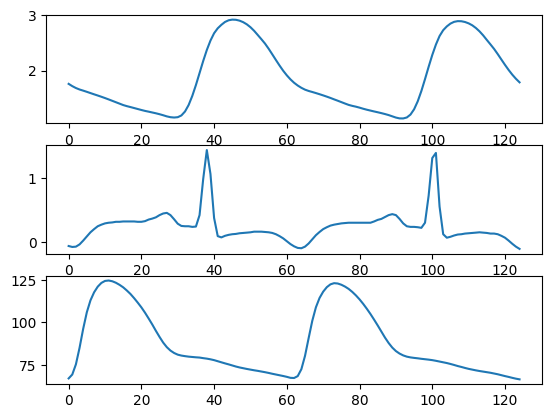

In [163]:
fig, ax = plt.subplots(3, 1)
ax[0].plot(ppg[:125])  # 1 second of PPG
ax[1].plot(ecg[:125])  # 1 second of ECG
ax[2].plot(bp[:125])   # 1 second of BP


* PPG =	Smooth rounded waveform. Typical of photoplethysmograph (PPG) signals from the fingertip. Peaks correspond to blood volume pulses.
* ECG	Sharp spikes =  (QRS complexes), typical of an ECG. Two clear heartbeats are visible.
* BP (ABP) = 	Classic blood pressure waveform, with a fast rise (systolic upstroke) and slow fall (diastolic downstroke).

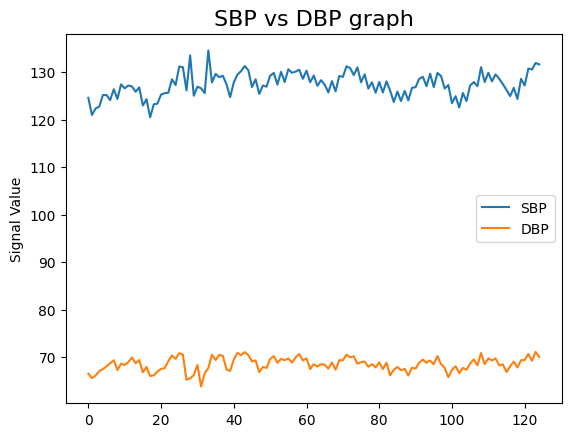

In [164]:

plt.title('SBP vs DBP graph', fontsize=16)
plt.ylabel('Signal Value')
plt.plot(sbp[:125])
plt.plot(dbp[:125])
plt.legend(['SBP', 'DBP'])

BP (Systolic BP) = Maximum pressure when the heart contracts.

DBP (Diastolic BP) = Minimum pressure when the heart relaxes

In [165]:
print(type(ppg), len(ppg))
print(type(bp), len(bp))


<class 'numpy.ndarray'> 32061000
<class 'numpy.ndarray'> 32061000


<class 'numpy.ndarray'> 32061000
[[67.06295517]
 [69.35862807]]


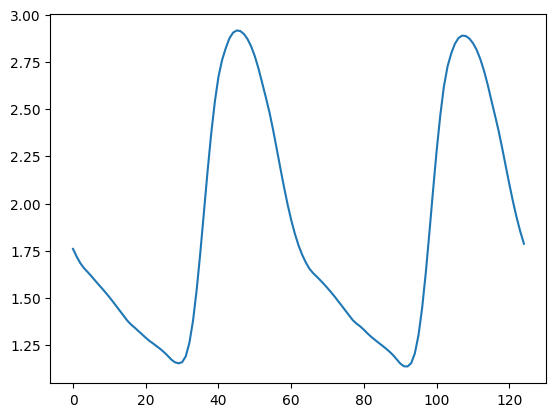

In [166]:
plt.plot(ppg[:125].squeeze())
print(type(bp), len(bp))
print(bp[:2])  # preview first 2 entries


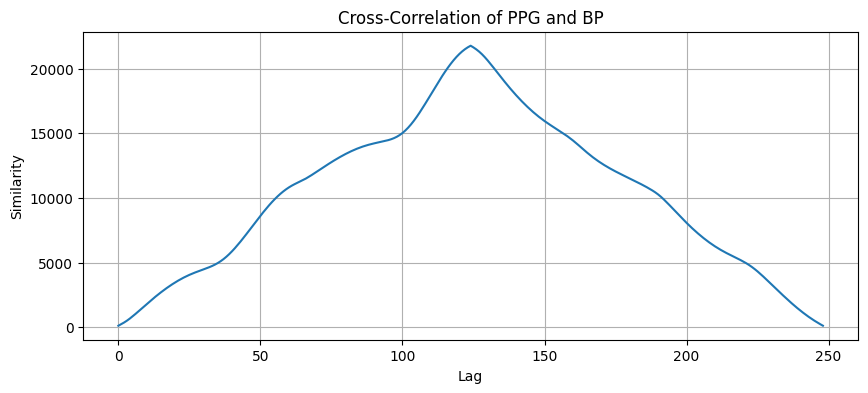

In [167]:
# Compute cross-correlation
cross_corr = np.convolve(ppg[:125].squeeze(), bp[:125].squeeze(), mode='full')

# Plot it
plt.figure(figsize=(10, 4))
plt.plot(cross_corr)
plt.title('Cross-Correlation of PPG and BP')
plt.xlabel('Lag')
plt.ylabel('Similarity')
plt.grid(True)
plt.show()


It slides PPG across BP and checks similarity at each step.

Peaks in the result show high similarity → helps find time delays or matching patterns.

In [168]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [169]:
from scipy.fftpack import dct

cosine_transformed_array = dct(ppg)
error = rmse(bp.squeeze(), cosine_transformed_array.squeeze())
print(f"RMSE between DCT(ppg) and BP: {error:.4f}")


RMSE between DCT(ppg) and BP: 92.6030


In [170]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(ppg, bp, test_size=0.30, random_state=42)


LINEAR REG

In [171]:
folds = KFold(n_splits=5, shuffle=False)
scores = []

for i, (train_index, val_index) in enumerate(folds.split(X_train, y_train)):
    train_data = X_train[train_index]
    target = y_train[train_index]
    validation_data = X_train[val_index]
    val_target = y_train[val_index]

    model = LinearRegression()
    model.fit(train_data, target)
    
    val_predictions = model.predict(validation_data)
    error = rmse(val_target, val_predictions)
    scores.append(error)
    
    print(f'Fold {i+1} RMSE: {error:.4f}')

print(f'\nAverage RMSE over 5 folds: {np.mean(scores):.4f}')


Fold 1 RMSE: 27.3494
Fold 2 RMSE: 27.3370
Fold 3 RMSE: 27.3344
Fold 4 RMSE: 27.3677
Fold 5 RMSE: 27.3323

Average RMSE over 5 folds: 27.3442


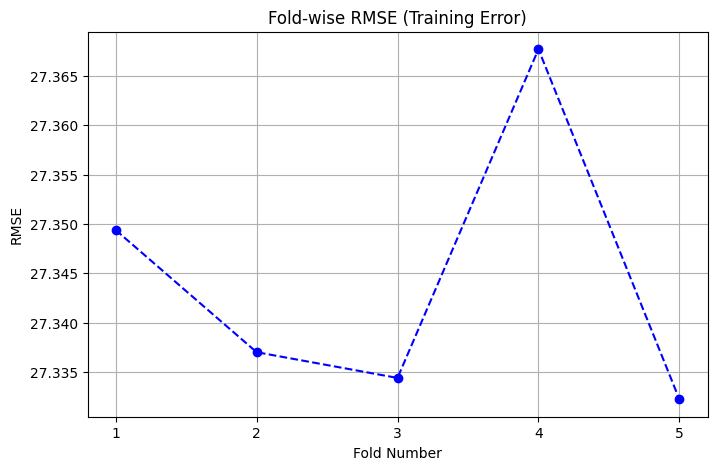

In [172]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(scores)+1), scores, marker='o', linestyle='--', color='b')
plt.title("Fold-wise RMSE (Training Error)")
plt.xlabel("Fold Number")
plt.ylabel("RMSE")
plt.xticks(range(1, len(scores)+1))
plt.grid(True)
plt.show()


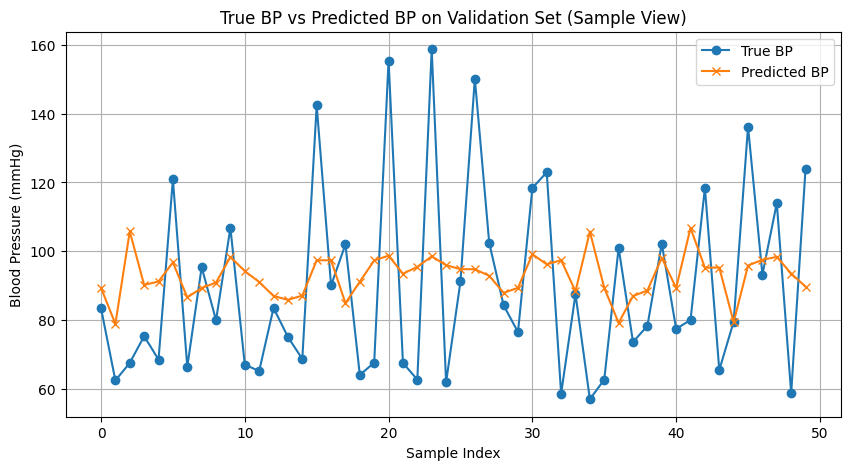

In [173]:
val_target      # true BP values
val_predictions # predicted BP values from model.predict()
plt.figure(figsize=(10, 5))
plt.plot(val_target[:50], label='True BP', marker='o')       # Plot first 50 samples
plt.plot(val_predictions[:50], label='Predicted BP', marker='x')
plt.title("True BP vs Predicted BP on Validation Set (Sample View)")
plt.xlabel("Sample Index")
plt.ylabel("Blood Pressure (mmHg)")
plt.legend()
plt.grid(True)
plt.show()


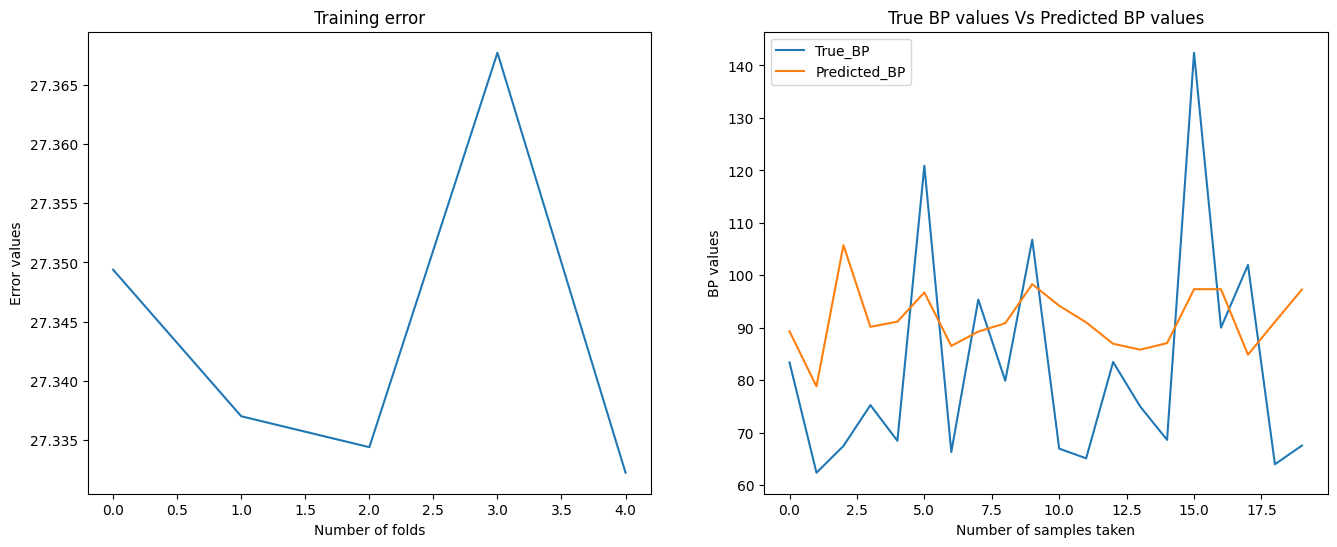

In [174]:
# Visualizing train error.
fig, ax = plt.subplots(1,2, figsize=(16,6))
ax[0].set_title("Training error")
ax[0].set_xlabel('Number of folds')
ax[0].set_ylabel('Error values')
ax[0].plot(scores)

# Visualize predicted BP and the True BP
ax[1].set_title("True BP values Vs Predicted BP values")
ax[1].set_xlabel('Number of samples taken')
ax[1].set_ylabel('BP values')
ax[1].plot(val_target[:20]) #only plotting 100 samples
ax[1].plot(val_predictions[:20])
ax[1].legend(['True_BP', 'Predicted_BP'])

In [180]:

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))


SUPPORT VECTOR MACHINES 

In [176]:
# Subsample to speed up SVM
X_small = ppg[:10000]
y_small = bp[:10000]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.30, random_state=42)

# K-Fold setup
folds = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

# Cross-validation loop
for i, (train_index, val_index) in enumerate(folds.split(X_train)):
    X_fold_train = X_train[train_index]
    y_fold_train = y_train[train_index]
    X_fold_val = X_train[val_index]
    y_fold_val = y_train[val_index]

    # SVM model
    model = SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1)
    model.fit(X_fold_train, y_fold_train)

    # Predict and evaluate
    y_val_pred = model.predict(X_fold_val)
    fold_rmse = rmse(y_fold_val, y_val_pred)
    scores.append(fold_rmse)

    print(f"Fold {i+1} RMSE: {fold_rmse:.4f}")

print(f"\nAverage RMSE over 5 folds (SVM): {np.mean(scores):.4f}")


Fold 1 RMSE: 27.5737
Fold 2 RMSE: 27.0737
Fold 3 RMSE: 26.9317
Fold 4 RMSE: 27.3604
Fold 5 RMSE: 27.3135

Average RMSE over 5 folds (SVM): 27.2506


In [ ]:
RANDOM FOREST

In [179]:


# Cross-validation loop
for i, (train_index, val_idx) in enumerate(folds.split(X_train)):
    X_fold_train = X_train[train_index]
    y_fold_train = y_train[train_index]
    X_fold_val = X_train[val_idx]
    y_fold_val = y_train[val_idx]

    # Random Forest Regressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_fold_train, y_fold_train)

    # Predict & evaluate
    y_val_pred = model.predict(X_fold_val)
    fold_rmse = rmse(y_fold_val, y_val_pred)
    scores.append(fold_rmse)

    print(f"Fold {i+1} RMSE: {fold_rmse:.2f}")

# Average RMSE across folds
print(f"\nAverage RMSE over 5 folds (Random Forest): {np.mean(scores):.2f}")


Fold 1 RMSE: 26.41
Fold 2 RMSE: 25.92
Fold 3 RMSE: 25.96
Fold 4 RMSE: 26.02
Fold 5 RMSE: 26.22

Average RMSE over 5 folds (Random Forest): 26.12
